In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os

from string import ascii_uppercase
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [575]:
AlgPath = '/mnt/home/geylon/ceph/data/NSRR/Results/SleepStagesComb/'
ManPath = '/mnt/home/geylon/ceph/data/NSRR/nchsdb/sleep_data/'
# os.chdir(MainPath)
filesAlg = [f for f in os.listdir(AlgPath) if f.endswith('.csv')]
filesMan = [f for f in os.listdir(ManPath) if f.endswith('.tsv')]

In [5]:
# read existing file
df_so = pd.read_csv('/mnt/home/geylon/ceph/data/NSRR/Results/SO_5consec2.csv', index_col=0)
df_fa = pd.read_csv('/mnt/home/geylon/ceph/data/NSRR/Results/fa_5consec2.csv', index_col=0)

In [602]:
filesAlg2 = [ f for f in filesAlg if f.replace('.csv','') not in df_so.index.tolist()]

In [431]:
def ind_consec_nonzero(lst):
    count = 0
    for i in range(len(lst)):
        if lst[i] != 0:
            count += 1
        else:
            count = 0

        if count == 5:
            return i - 4  # Return the starting index of the five consecutive nonzero elements

    return None  # Return None if no such occurrence is found


In [603]:
### this one
# df_fa = pd.DataFrame(columns = ['Man','Yasa','U'])
# df_so = pd.DataFrame(columns = ['Man','Yasa','U'])
for f in range(len(filesAlg2)):
# for f in range(100):
    file = filesAlg2[f]
    fileName = file.replace('.csv','')
    
    # load algo stages
    dataAlg = pd.read_csv(os.path.join(AlgPath,file), index_col = 0)
    dataAlg.U.replace([3,4],[4,3], inplace = True)
    
    # yasa majority vote
    numcols = len(dataAlg.columns)
    stagescols = dataAlg.columns[np.arange(0,numcols-1,2)]
    confcols = dataAlg.columns[np.arange(1,numcols,2)]
    selectedstages = []
    for j in range(dataAlg.shape[0]):
        epochdata = dataAlg.loc[j,dataAlg.columns[0:numcols-1]]
        epochstages = epochdata.loc[stagescols]
        epochconf = epochdata.loc[confcols] 
        epochstagesUnq = np.unique(dataAlg.loc[j,stagescols].values)
        pd_conf = pd.DataFrame(index = epochstagesUnq, columns = ['conf'], dtype = int)
        for i in epochstagesUnq:
            confs = [f.replace('Y','Y_conf') for f in epochstages.index[epochstages==i]]
            # confs
            pd_conf.loc[i,'conf'] = np.mean(epochdata[confs].values)
        selectedstages.append(pd_conf.idxmax().values.astype(int)[0])
    
    # manual sleep stages
    dataMan = pd.read_csv(os.path.join(ManPath,file.replace('.csv','.tsv')), sep = '\t')
    # get only sleep events
    dataMan = dataMan[dataMan['description'].str.match('^Sleep.*')==True]
    # insert epoch count
    dataMan['epoch'] = (round(dataMan['onset']/30)).astype(int)
    # drop irrelevant coulmns
    dataMan = dataMan.drop(['onset','duration'], axis=1).reset_index(drop = True)
    if dataMan.shape[0] !=0:
        # create dataframe to fill missing epochs 
        df_to_join = pd.DataFrame({'description':'Sleep stage W','epoch': np.arange(1,dataMan['epoch'][0])})
        #concat dfs
        dataMan = pd.concat([df_to_join, dataMan], ignore_index = True)
        dataMan.replace(regex={r'.*W.*':0,r'.*R.*':1,r'.*1.*':2, r'.*2.*':3, r'.*3.*':4,r'.*?.*':0}, inplace=True)
        # dataMan.replace(regex={r'.*W.*':0,r'.*R.*':1,r'.*N1.*':2, r'.*N2.*':3, r'.*N3.*':4,r'.*?.*':0}, inplace=True)

        if ((len(np.nonzero(dataMan.description.values)[0]) !=0) &
            (len(np.nonzero(dataAlg.U.values)[0]) !=0) & (len(np.nonzero(selectedstages)) !=0)):
            # extract so
            df_so.loc[fileName,'Yasa'] = ind_consec_nonzero(selectedstages)
            df_so.loc[fileName,'Man'] = ind_consec_nonzero(dataMan.description.values.tolist())
            df_so.loc[fileName,'U'] = ind_consec_nonzero(dataAlg.U.values.tolist())

            # extract fa
            df_fa.loc[fileName,'Yasa'] = len(selectedstages)-ind_consec_nonzero(selectedstages[::-1])
            df_fa.loc[fileName,'Man'] = dataMan.shape[0]-ind_consec_nonzero(dataMan.description.values.tolist()[::-1])
            df_fa.loc[fileName,'U'] = dataMan.shape[0]-ind_consec_nonzero(dataAlg.U.values.tolist()[::-1])
        else:
            df_so.loc[fileName,'Yasa'] = df_fa.loc[fileName,'Yasa'] = np.nan
            print('Faulty file: '+fileName +', N epochs: ' + str(dataAlg.shape[0])+
                 ', U stages: ' + str(np.unique(dataAlg.U.values).tolist())+
                 ', Yasa stages: ' + str(np.unique(selectedstages))+
                 ', Man stages: '+ str(np.unique(dataMan.description.values).tolist()))
    # print(f)


Faulty file: 9361_9025, N epochs: 102, U stages: [0], Yasa stages: [0 1 2 3 4], Man stages: [0]
Faulty file: 16933_26176, N epochs: 536, U stages: [0, 2, 3], Yasa stages: [0 1 3 4], Man stages: [0]
Faulty file: 15118_1519, N epochs: 316, U stages: [0, 3], Yasa stages: [0 1 3 4], Man stages: [0]
Faulty file: 11527_7306, N epochs: 230, U stages: [0, 2, 3], Yasa stages: [0 1 3 4], Man stages: [0]


In [606]:
df_so.to_csv('/mnt/home/geylon/ceph/data/NSRR/Results/SO_5consec2.csv')
df_fa.to_csv('/mnt/home/geylon/ceph/data/NSRR/Results/fa_5consec2.csv')

### check single files

In [478]:
df_fa3 = pd.DataFrame(columns = ['Man','Yasa','U'])
df_so3 = pd.DataFrame(columns = ['Man','Yasa','U'])
# for f in range(len(filesAlg)):
# for f in range(100):
file = '3607_4252.csv'
fileName = file.replace('.csv','')

# load algo stages
dataAlg = pd.read_csv(os.path.join(AlgPath,file), index_col = 0)
dataAlg.U.replace([3,4],[4,3], inplace = True)

# yasa majority vote
numcols = len(dataAlg.columns)
stagescols = dataAlg.columns[np.arange(0,numcols-1,2)]
confcols = dataAlg.columns[np.arange(1,numcols,2)]
selectedstages = []
for j in range(dataAlg.shape[0]):
    epochdata = dataAlg.loc[j,dataAlg.columns[0:numcols-1]]
    epochstages = epochdata.loc[stagescols]
    epochconf = epochdata.loc[confcols] 
    epochstagesUnq = np.unique(dataAlg.loc[j,stagescols].values)
    pd_conf = pd.DataFrame(index = epochstagesUnq, columns = ['conf'], dtype = int)
    for i in epochstagesUnq:
        confs = [f.replace('Y','Y_conf') for f in epochstages.index[epochstages==i]]
        # confs
        pd_conf.loc[i,'conf'] = np.mean(epochdata[confs].values)
    selectedstages.append(pd_conf.idxmax().values.astype(int)[0])

# manual sleep stages
dataMan = pd.read_csv(os.path.join(ManPath,file.replace('.csv','.tsv')), sep = '\t')
# get only sleep events
dataMan = dataMan[dataMan['description'].str.match('^Sleep.*')==True]
# insert epoch count
dataMan['epoch'] = (round(dataMan['onset']/30)).astype(int)
# drop irrelevant coulmns
dataMan = dataMan.drop(['onset','duration'], axis=1).reset_index(drop = True)
# create dataframe to fill missing epochs 
df_to_join = pd.DataFrame({'description':'Sleep stage W','epoch': np.arange(1,dataMan['epoch'][0])})
#concat dfs
dataMan = pd.concat([df_to_join, dataMan], ignore_index = True)
dataMan.replace(regex={r'.*W.*':0,r'.*R.*':1,r'.*1.*':2, r'.*2.*':3, r'.*3.*':4,r'.*?.*':0}, inplace=True)
# dataMan.replace(regex={r'.*W.*':0,r'.*R.*':1,r'.*N1.*':2, r'.*N2.*':3, r'.*N3.*':4,r'.*?.*':0}, inplace=True)

if ((len(np.nonzero(dataMan.description.values)[0]) !=0) &
    (len(np.nonzero(dataAlg.U.values)[0]) !=0) & (len(np.nonzero(selectedstages)) !=0)):
    # extract so
    df_so3.loc[fileName,'Yasa'] = ind_consec_nonzero(selectedstages)
    df_so3.loc[fileName,'Man'] = ind_consec_nonzero(dataMan.description.values.tolist())
    df_so3.loc[fileName,'U'] = ind_consec_nonzero(dataAlg.U.values.tolist())

    # extract fa
    df_fa3.loc[fileName,'Yasa'] = len(selectedstages)-ind_consec_nonzero(selectedstages[::-1])
    df_fa3.loc[fileName,'Man'] = dataMan.shape[0]-ind_consec_nonzero(dataMan.description.values.tolist()[::-1])
    df_fa3.loc[fileName,'U'] = dataMan.shape[0]-ind_consec_nonzero(dataAlg.U.values.tolist()[::-1])
else:
    df_so3.loc[fileName,'Yasa'] = df_fa3.loc[fileName,'Yasa'] = np.nan
    print('Faulty file: '+fileName)
# print(f)


Faulty file: 3607_4252


# Bland Altman

In [6]:
def ba_plot(data1,data2,titleName,clr,ax):
    ydiff = data2-data1
    ymean = np.round(np.nanmean(ydiff),2)
    ysd = np.nanstd(ydiff)
    CI_l = np.round(ymean-1.96*ysd,2)
    CI_h = np.round(ymean+1.96*ysd,2)
    ax.scatter(data1, ydiff,6,c = clr)
    # mean bias
    ax.axhline(ymean, color = 'black',linestyle = '--')
    ax.annotate(f" bias = {ymean}",xy = (ax.get_xlim()[1],ymean),
            horizontalalignment='left',verticalalignment='center',xycoords = 'data')
    # LOA
    ax.axhline(CI_l, color='red', linestyle='--')
    ax.annotate(f" -1.96 x SD = {CI_l}",xy = (ax.get_xlim()[1],CI_l),
            horizontalalignment='left',verticalalignment='center',xycoords = 'data')
    
    ax.axhline(CI_h, color='red', linestyle='--')
    ax.annotate(f" +1.96 x SD = {CI_h}",xy = (ax.get_xlim()[1],CI_h),
        horizontalalignment='left',verticalalignment='center',xycoords = 'data')
    
    ax.set_title(titleName)
    # annotations
    # ax.annotate(f" bias = {ymean}",xy = (ax.get_xlim()[1],ymean),
    #             horizontalalignment='left',verticalalignment='center',xycoords = 'data')

## Sleep Onset

In [78]:
# plt.rcParams['font.family'] = 'sans-serif'

Text(0.45, 0, 'Manual')

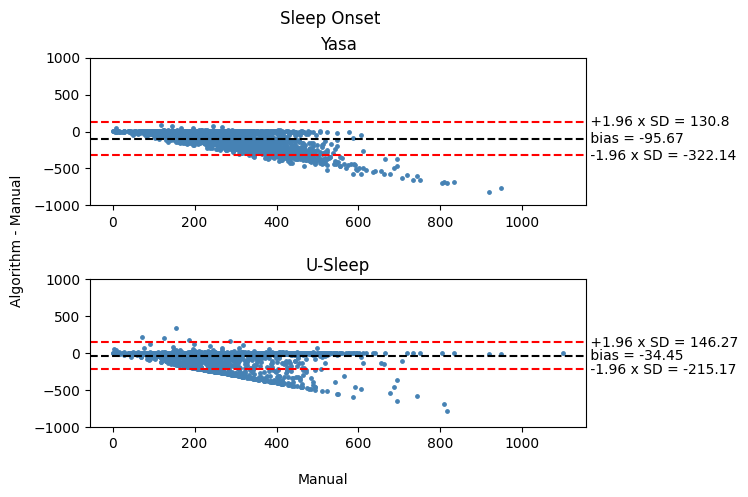

In [89]:
fig, axs = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.5)
ax1, ax2 = axs[0], axs[1]
ba_plot(df_so.Man.values,df_so.Yasa.values,'Yasa','steelblue',ax1)
ba_plot(df_so.Man.values,df_so.U.values,'U-Sleep','steelblue',ax2)
plt.setp(axs, ylim = (-1000, 1000))
fig.suptitle('Sleep Onset')
fig.text(0, 0.5, 'Algorithm - Manual', va = 'center', rotation = 'vertical')
fig.text(0.45, 0, 'Manual', va = 'center')
# plt.savefig('/mnt/home/geylon/ceph/data/NSRR/Results/figs/SO_BA.jpg')
# ax1.text

## Final Awakening

Text(0, 0.5, 'Algorithm - Manual')

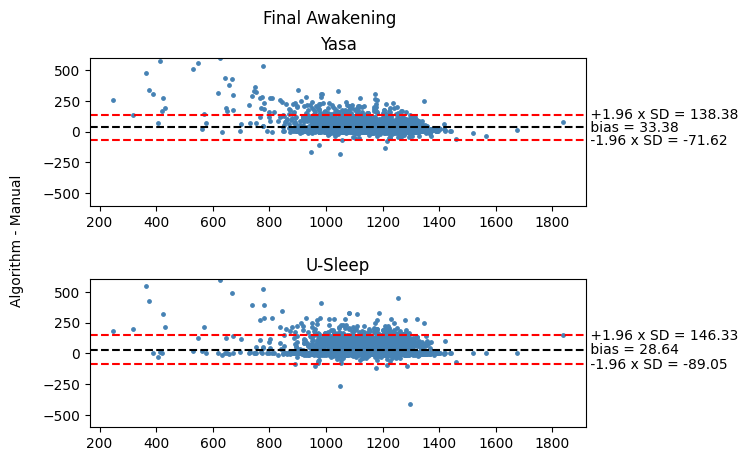

In [8]:
fig, axs = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.5)
ax1, ax2 = axs[0], axs[1]
ba_plot(df_fa.Man.values,df_fa.Yasa.values,'Yasa','steelblue',ax1)
ba_plot(df_fa.Man.values,df_fa.U.values,'U-Sleep','steelblue',ax2)
plt.setp(axs, ylim = (-600, 600))
fig.suptitle('Final Awakening')
fig.text(0, 0.5, 'Algorithm - Manual', va = 'center', rotation = 'vertical')
# ax1.text

In [9]:
# calculate differences
df_so['Yasa-Man'] = df_so.Yasa-df_so.Man
df_so['U-Man'] = df_so.U-df_so.Man
df_fa['Yasa-Man'] = df_fa.Yasa-df_fa.Man
df_fa['U-Man'] = df_fa.U-df_fa.Man

Text(0.5, 1.0, 'Final Awakening')

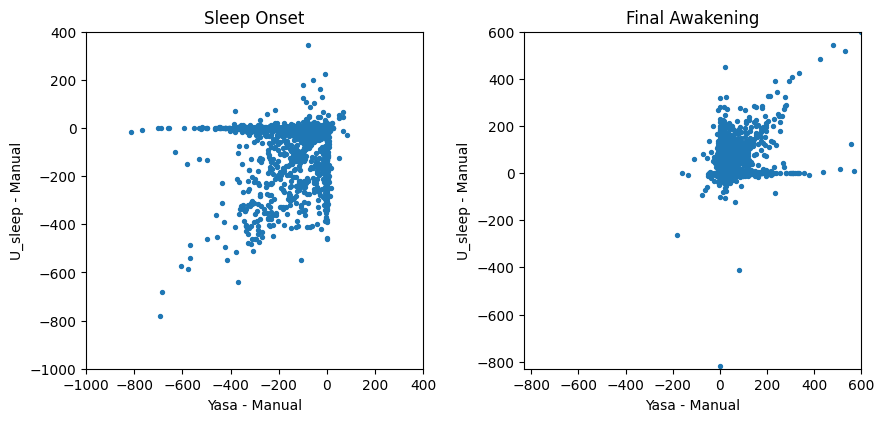

In [90]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
# axs.set_aspect('equal')
fig.subplots_adjust(wspace=0.3)
ax1, ax2 = axs[0], axs[1]

ax1.scatter(df_so['Yasa-Man'],df_so['U-Man'],8)
# ax1.set_aspect('equal',adjustable='box')
ax1.axis('square')
ax1.set_xlim([-1000, 400])
ax1.set_ylim([-1000, 400])
ax1.set_xlabel('Yasa - Manual')
ax1.set_ylabel('U_sleep - Manual')
ax1.set_title('Sleep Onset')

ax2.scatter(df_fa['Yasa-Man'],df_fa['U-Man'],8)
ax2.axis('square')
ax2.set_xlim([-830, 600])
ax2.set_ylim([-830, 600])
# ax2.set_aspect('equal',adjustable='box')
ax2.set_xlabel('Yasa - Manual')
ax2.set_ylabel('U_sleep - Manual')
ax2.set_title('Final Awakening')
# plt.show()

(-830.0, 600.0)

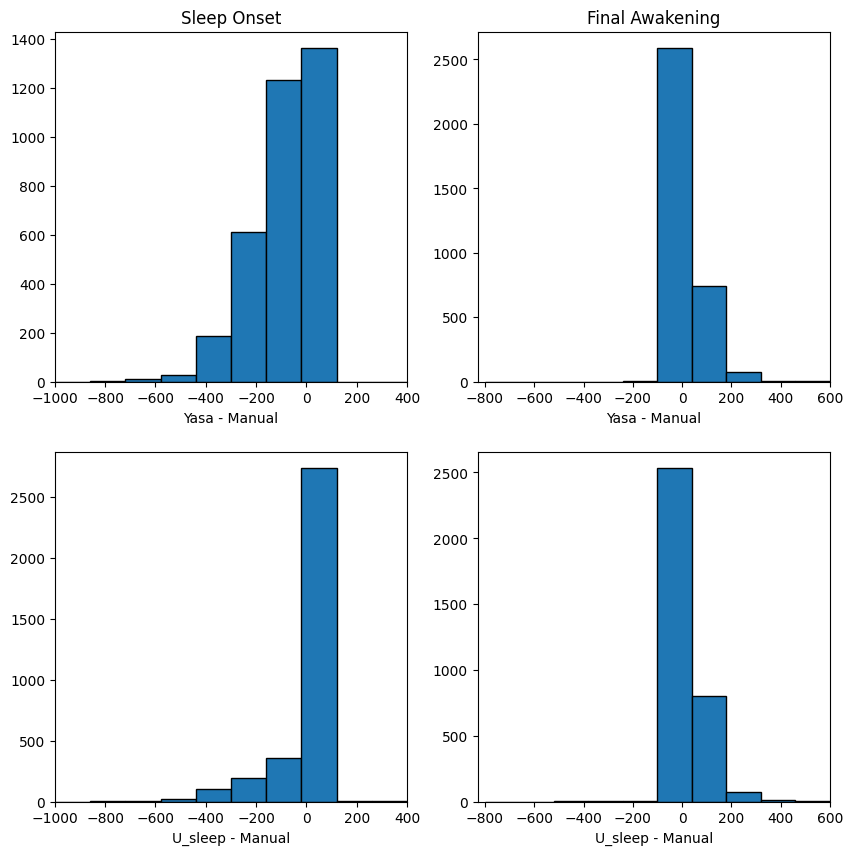

In [63]:
fig, axs = plt.subplots(2,2, figsize = (10,10))
ax1,ax2,ax3,ax4  = axs[0][0],axs[1][0],axs[0][1],axs[1][1];
# axs.set_aspect('equal')
# fig.subplots_adjust(wspace=0.3)
# ax1, ax2 = axs[0], axs[1]

ax1.hist(df_so['Yasa-Man'], bins=10, range = (-1000, 400),histtype='bar',edgecolor='k')
ax1.set_xlabel('Yasa - Manual')
ax1.set_xlim([-1000, 400])
ax1.set_title('Sleep Onset')
ax2.hist(df_so['U-Man'], bins=10,range = (-1000, 400), histtype='bar',edgecolor='k')
ax2.set_xlabel('U_sleep - Manual')
ax2.set_xlim([-1000, 400])

ax3.hist(df_fa['Yasa-Man'], bins=10, range = (-800, 600),histtype='bar',edgecolor='k')
ax3.set_xlabel('Yasa - Manual')
ax3.set_xlim([-830, 600])
ax3.set_title('Final Awakening')
ax4.hist(df_fa['U-Man'], bins=10, range = (-800, 600),histtype='bar',edgecolor='k')
ax4.set_xlabel('U_sleep - Manual')
ax4.set_xlim([-830, 600])

# # ax1.set_aspect('equal',adjustable='box')
# ax1.axis('square')
# ax1.set_xlim([-1000, 400])
# ax1.set_ylim([-1000, 400])
# ax1.set_xlabel('Yasa - Manual')
# ax1.set_ylabel('U_sleep - Manual')
# ax1.set_title('Sleep Onset')

# ax2.scatter(df_fa['Yasa-Man'],df_fa['U-Man'],6)
# ax2.axis('square')
# ax2.set_xlim([-830, 600])
# ax2.set_ylim([-830, 600])
# # ax2.set_aspect('equal',adjustable='box')
# ax2.set_xlabel('Yasa - Manual')
# ax2.set_ylabel('U_sleep - Manual')
# ax2.set_title('finalAwakening')
# plt.show()

In [45]:
plt.close('all')

In [33]:
df_fa.loc[df_fa['Yasa-Man']>500]

,Man,Yasa,U,Yasa-Man,U-Man
18490_13417,624.0,1222.0,1221.0,598.0,597.0
16492_8944,529.0,1041.0,546.0,512.0,17.0
4909_23506,412.0,983.0,419.0,571.0,7.0
9019_22558,549.0,1106.0,671.0,557.0,122.0
6409_22402,776.0,1308.0,1296.0,532.0,520.0


In [358]:
df_so1.loc[df_so1['Man-Yasa']>500]

,Man,Yasa,U,Man-Yasa
67_5998,820,64,127,756
19918_6244,520,2,5,518
18550_6253,1100,72,1103,1028
12013_22681,596,76,598,520
14623_8203,547,8,206,539
15016_14170,641,108,16,533
13393_1213,695,19,1,676
20359_9712,594,87,595,507
17479_7291,733,75,524,658
20182_16099,618,97,619,521
